In [74]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h2o


In [75]:
#reading data and preprocessing

train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

#X_train_estimated_a.to_csv('train_est_a.csv')

def preprocessing(data):
    if 'date_calc' in data.columns:
        data.drop('date_calc', axis=1, inplace=True)
    
    data['hour'] = data['date_forecast'].dt.hour
    data['month'] = data['date_forecast'].dt.month

    data.set_index('date_forecast', inplace=True)

    data = data.groupby(pd.Grouper(freq='1H')).mean()
    data.dropna(how='all', inplace=True)

    data['snow_density:kgm3'].fillna(0.0, inplace=True)

    """lag_window_size = 1  # Example lag window size
    feature_columns = data.columns  # Get a list of all feature columns

    for feature in feature_columns:
        for i in range(1, lag_window_size + 1):
            data[f'{feature}_lag_{i}'] = data[feature].shift(i)"""
    
    data.interpolate(method='time', inplace=True)
    
    data.rename_axis('time', inplace=True)
    

    return data


#combining observed and estimated data
x_train_a = pd.concat([X_train_observed_a, X_train_estimated_a], axis=0)
x_train_a = preprocessing(x_train_a)

x_train_b = pd.concat([X_train_observed_b, X_train_estimated_b], axis=0)
x_train_b = preprocessing(x_train_b)

x_train_c = pd.concat([X_train_observed_c, X_train_estimated_c], axis=0)
x_train_c = preprocessing(x_train_c)

#adding labels
train_a.set_index('time', inplace=True)
train_a.fillna(0.0, inplace=True)
x_train_a = x_train_a.merge(train_a, how='inner', on='time')

train_b.set_index('time', inplace=True)
train_b.fillna(0.0, inplace=True)
x_train_b = x_train_b.merge(train_b, how='inner', on='time')

train_c.set_index('time', inplace=True)
train_c.fillna(0.0, inplace=True)
x_train_c = x_train_c.merge(train_c, how='inner', on='time')

x_train = pd.concat([x_train_a, x_train_b, x_train_c], axis=0, ignore_index=True)


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

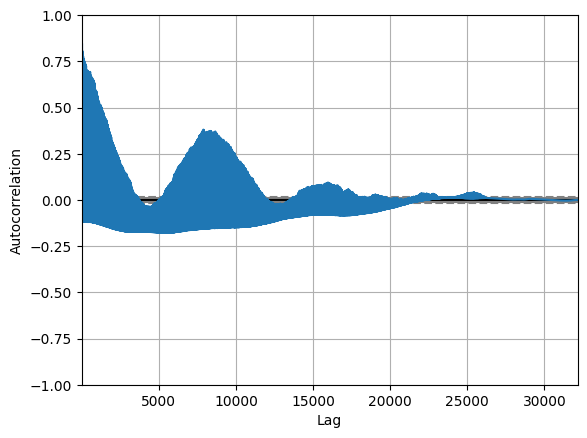

In [67]:
#exploratory data analysis and vizualization 

from pandas.plotting import autocorrelation_plot

autocorrelation_plot(train_c)

In [78]:


def train(model):
    if model.lower() == 'a':
        automl_df=x_train_a
    elif model.lower() == 'b':
        automl_df=x_train_b
    elif model.lower() == 'c':
        automl_df=x_train_c
    elif model.lower() == 's':
        automl_df=x_train
    else:
        return

    h2o.init()
    train_df = h2o.H2OFrame(automl_df)
    train_df.describe()

    test = h2o.H2OFrame(automl_df)
    x = test.columns
    y = 'pv_measurement'
    x.remove(y)

    # import autoML from H2O
    from h2o.automl import H2OAutoML
    # callh20automl  function
    aml = H2OAutoML(max_runtime_secs = 120,
                    sort_metric='MAE'
    )
    # train model and record time % time
    aml.train(x = x, y = y, training_frame = test)

    # Obtain the leader model
    best_model = aml.leader

    # Save the leader model
    model_path = h2o.save_model(model=best_model, path="/tmp/mymodel", force=True)

    # Load the saved model
    loaded_model = h2o.load_model(model_path)

    # Download the model to local machine
    my_local_model = h2o.download_model(best_model, path=f"./models/{model.upper()}")

    h2o.cluster().shutdown()

    return my_local_model

 

In [79]:
my_local_model_all = train('s')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,10 mins 35 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_olelasson_40ccoo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.421 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:99014
Cols:48

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hour,month,pv_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,int,real
mins,0.5,1.1392500400543213,27.799999237060547,0.0,0.0,27.5,-1.0,247.4250030517578,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.375,0.0,0.0,929.9749755859376,935.75,0.0,0.0,19.575000762939453,941.5499877929688,0.0,0.0,0.0,0.0,0.0,6.982999801635742,-49.93199920654297,0.0,258.0249938964844,0.0,132.375,0.02500000037252903,-7.224999904632568,-8.399999618530273,-0.10000000149011612,0.0,1.0,0.0
mean,6.047586706134849,1.2550115512246531,3150.95815076531,529168.55259402,146.99231393388376,1879.728883414517,0.004900822105964813,275.29335070501037,40.37591755433746,145348.23799427925,51.389801436288636,185001.93913569482,67.02690959432749,12.172490758882587,0.12394459354430375,0.010295261345900206,0.24545266308433802,0.030954208544325637,0.06195891488779988,0.48957723150261623,0.5595723837033141,1009.6110852936711,0.005677580937093536,0.08434665804835684,995.8209642762458,1001.9499131165958,0.8196606037290309,0.00956001188195547,73.57963797977101,1008.1061538220712,12.983012503282364,0.29524461236593735,2.7773850162603267e-05,0.0003448754695966531,0.08942977845800322,179.63003296478104,-0.7530374983665187,0.05752999680248639,279.51160815637314,73.63940479962187,33024.318089070344,3.0207137365094026,0.6687978472176545,0.6669773963931908,5.2265337050330715e-05,11.5013836427172,6.189629749328379,269.64400470525965
maxs,18.700000762939453,1.440999984741211,12294.9013671875,2990595.5,835.6500244140625,11673.724609375,1.0,294.92498779296875,334.75,1198315.125,683.4000244140625,2441810.5,100.0,24.0,37.474998474121094,7.25,37.474998474121094,20.325000762939453,33.375,1.0,1.0,1044.0999755859375,0.6225000023841858,5.0,1030.875,1037.25,96.7750015258789,1.100000023841858,100.0,1043.7249755859375,250.0,25.950000762939453,1.0,0.18000000715255737,5.650000095367432,348.4875183105469,49.943748474121094,1.375,303.25,100.0,75489.328125,13.274999618530272,11.199999809265137,8.824999809265137,0.10000000149011612,23.0,12.0,5733.42
sigma,2.7443584542869255,0.03680622617412614,2700.2139158980335,829236.2297312977,230.9300000485744,1940.982139486639,0.2408068410074405,6.890142314322381,61.24571990454919,217873.58176530965,114.19930158912051,405798.14486005856,34.29876043661443,8.207947131465028,0.7899664780123267,0.10505205185477372,1.2579459086094131,0.2760061364976387,0.47963273725434635,0.4861534364742998,0.4837009649787938,13.000494402715718,0.028974547298651492,0.3292292006736318,12.910724537609802,12.967712546965453,5.565308714823626,0.0410049891122276,14.336951776339259,13.026894019003574,55.472746379208715,1.8089914848362818,0.004700243301439377,0.004805620004453144,0.23573185143093495,97.40514156283156,24.010154072864758,0.10653099562003665,6.5828165363446836,34.02867107551231,17852.905234400125,1.7497160893415225,2.7812799496436402,1.8766130696599523,0.00640475785609368,6.920768516443817,3.5448926846071114,746.0115031487045
zeros,0,0,0,43226,47363,0,91852,0,47382,43235,54774,49719,3645,0,92572,96927

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
H2O session _sid_9a99 closed.


In [69]:
my_local_model_A = train('a')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 mins 48 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_olelasson_9ntsfj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.188 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:34061
Cols:48

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hour,month,pv_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,int,real,real,real,real,real,real,real,real,real,real,real,real,int,int,real
mins,0.699999988079071,1.1449999809265137,27.849998474121097,0.0,0.0,27.799999237060547,-1.0,251.0749969482422,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.4000244140624,0.0,0.0,932.4000244140624,938.2000122070312,0.0,0.0,21.700000762939453,944.0,0.0,0.0,0.0,0.0,0.0,6.982999801635742,-49.89399719238281,0.0,259.0,0.0,159.6750030517578,0.02500000037252903,-7.224999904632568,-8.399999618530273,0.0,0.0,1.0,0.0
mean,6.322320250351401,1.2532797771004038,3300.501445790256,552671.1678821972,153.51968819845212,1872.8618892791128,0.020668800093949093,275.97182254114244,42.06996638320775,151451.71881457855,52.62769958820423,189459.87623030285,67.70161258036258,6.0,0.08820278320963196,0.007402894869658933,0.17359516759169832,0.02228942194988068,0.04440489122286148,0.4991852852235699,0.5353483456152195,1009.603843063803,0.006014650169552615,0.0890754822230704,996.7075658886545,1002.8290874581662,0.23188544087143018,0.0107828603490834,74.02536330787697,1008.9778176316054,8.367340947124276,0.07350855843764993,0.0,0.00012727165757659995,0.0896883540659685,179.63674567712494,-0.04687209569277345,0.05566483764321577,279.9364118813764,74.31900637064247,32577.394217938363,3.061313524594808,0.6572061894577825,0.5701616212857115,1.6881477601014875e-05,11.500954170458902,6.541499075188637,631.0111649687328
maxs,17.350000381469727,1.4262499809265137,12294.9013671875,2988627.5,835.0999755859375,11673.625,1.0,293.625,332.2749938964844,1191085.25,683.4000244140625,2441749.5,100.0,6.0,15.0,3.549999952316284,15.0,7.875,14.225000381469728,1.0,1.0,1043.949951171875,0.6225000023841858,3.75,1030.875,1037.25,91.875,1.100000023841858,100.0,1043.7249755859375,250.0,6.300000190734863,0.0,0.13249999284744263,5.650000095367432,348.48651123046875,49.90550231933594,1.2999999523162842,303.25,100.0,69395.5234375,13.274999618530272,11.199999809265137,8.25,0.10000000149011612,23.0,12.0,5733.42
sigma,2.799442323741874,0.03720644592716358,2745.4958027370953,848338.9524549864,236.24473088072932,1968.5202884119785,0.1852969847046359,6.892324036977613,62.8385233773589,223524.79904018878,115.25055669696049,409345.4349368961,33.808253285702605,0.0,0.5945263496675198,0.08363566233487284,0.9281759804668741,0.2141134034093852,0.3667132677670624,0.4861571690937141,0.48665592243719435,12.739137877864016,0.030217786318958405,0.3236889172912679,12.603231746387415,12.659498234019072,2.80325699589278,0.043944979795541676,13.881200569168275,12.717940639972545,44.96534446525811,0.46848760865667327,0.0,0.0026485422313329014,0.2375475612408994,97.65791732299918,24.15515029849285,0.1039186668394868,6.664930199350173,33.49235436406495,17701.938312145772,1.774981540205253,2.8897352083282946,1.8371422374293822,0.0011572652695004493,6.9230889682910455,3.4791071364276323,1166.2060656312103
zeros,0,0,0,14533,15958,0,32520,0,15966,14536,18178,16399,1091,0,32398,33532,31467,33268,32948,15952,14819,0,30325,30325,0,0,33463,30968,0,0,32921,32921,34061

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
22:08:13.219: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██████████████
22:08:40.724: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██
22:08:43.636: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██████████████
22:09:10.471: _train param, Dropping unused columns: [snow_drift:idx, elevation:m]
22:09:11.262: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█████
22:09:20.436: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█████
22:09:29.831: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█████
22:09:39.32: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█████
22:09:48.236: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation

In [70]:
my_local_model_B = train('b')


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpdfqxd398
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpdfqxd398/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpdfqxd398/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_olelasson_c0ijtw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.770 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:32823
Cols:48

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hour,month,pv_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,int,real
mins,0.699999988079071,1.1514999866485596,27.849998474121097,0.0,0.0,27.975000381469727,-1.0,251.0500030517578,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.5,0.0,0.0,932.2999877929688,938.0499877929688,0.0,0.0,19.575000762939453,943.8499755859376,0.0,0.0,0.0,0.0,0.0,6.983749866485596,-49.89324951171875,0.0,259.0249938964844,0.0,174.72500610351562,0.05000000074505806,-7.224999904632568,-8.399999618530273,0.0,0.0,1.0,0.0
mean,5.9347957224811365,1.256661037939966,3059.5395379052666,512902.6366075613,142.47889892300043,1865.3679760820564,0.009124699143893,275.06226731543717,39.26133655832332,141327.62822586964,50.75617096656453,182716.64480217887,66.93586510039255,7.0,0.09080065798358404,0.007415531842305375,0.18055479398559476,0.02241644576074775,0.04513450929685586,0.4828169271547392,0.551952898881882,1009.5591375956844,0.005444124536026124,0.07982969259360831,996.5044755655871,1002.6418966131729,0.06109663914839498,0.008981507025581675,73.24079683638136,1008.8067331549136,12.232276147823173,0.3151243037384699,6.093288243000335e-05,0.0002798342611002274,0.0895073584710236,179.61566186158257,-1.2439928409331253,0.05690598160156034,279.1957004069337,73.51160239307673,33167.67353655816,3.1354263771764703,0.6693332423002727,0.5727279644835279,2.437315339193779e-05,11.50092922645706,5.965786186515559,96.88152734017498
maxs,17.350000381469727,1.4254999160766602,12285.775390625,2988610.25,835.0999755859375,11673.724609375,1.0,293.6000061035156,332.2749938964844,1190978.0,683.4000244140625,2441810.5,100.0,7.0,12.25,3.125,14.975000381469728,7.875,12.25,1.0,1.0,1044.0999755859375,0.5849999785423279,3.75,1030.7249755859375,1037.14990234375,73.0999984741211,0.8999999761581421,100.0,1043.5999755859375,250.0,18.200000762939453,1.0,0.18000000715255737,3.549999952316284,348.4875183105469,49.90550231933594,1.2999999523162842,303.25,100.0,68500.0,13.274999618530272,11.199999809265137,8.225000381469727,0.10000000149011612,23.0,12.0,1152.3
sigma,2.6733015458304363,0.03501654643264692,2651.6805707616454,815860.9756618454,227.20648464277548,1885.4352534731024,0.11439518247033421,6.7044046649521265,60.15081841559347,213995.73686398726,113.64040800963126,403948.1469406994,34.16418409239231,0.0,0.5939187360243401,0.07638391886831083,0.9933638633380001,0.19945548495607593,0.3477638073162785,0.48603553252183335,0.48484417895015613,13.1493415654034,0.0281856011233768,0.3248682604231408,13.02987064257542,13.087873550232414,1.243873570276369,0.039342713517744876,14.296062823103037,13.147938766024536,53.93078035527684,1.8226706551835832,0.007036033145360896,0.0046789392194830646,0.2344749135580239,97.24480764109713,23.907377191143343,0.10546940666065086,6.516543004088568,33.908731267713655,17828.187633275742,1.8230331169745173,2.9773977983109665,1.8643909718088925,0.0014070483335347358,6.920396902842379,3.570518292073481,193.99521174440451
zeros,0,0,0,14555,15927,0,32234,0,15931,14557,17965,16305,1211,0,311

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
22:10:43.836: _train param, Dropping bad and constant columns: [elevation:m]

█████████████████
22:11:16.396: _train param, Dropping bad and constant columns: [elevation:m]

██
22:11:19.897: _train param, Dropping bad and constant columns: [elevation:m]

███████████████████
22:11:57.810: _train param, Dropping unused columns: [elevation:m]

█
22:11:58.562: _train param, Dropping bad and constant columns: [elevation:m]

███
22:12:05.489: _train param, Dropping bad and constant columns: [elevation:m]

████
22:12:12.620: _train param, Dropping bad and constant columns: [elevation:m]

████
22:12:19.289: _train param, Dropping bad and constant columns: [elevation:m]

███
22:12:26.36: _train param, Dropping bad and constant columns: [elevation:m]

████
22:12:32.808: _train param, Dropping unused columns: [elevation:m]
22:12:33.221: _train param, Dropping unused columns: [elevatio

In [71]:
my_local_model_C = train('c')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpgr25k6hy
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpgr25k6hy/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpgr25k6hy/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_olelasson_m5wl04
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.770 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:32130
Cols:48

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hour,month,pv_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,int,real
mins,0.5,1.1392500400543213,27.799999237060547,0.0,0.0,27.5,-1.0,247.4250030517578,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.375,0.0,0.0,929.9749755859376,935.75,0.0,0.0,20.125,941.5499877929688,0.0,0.0,0.0,0.0,0.0,6.982999801635742,-49.93199920654297,0.0,258.0249938964844,0.0,132.375,0.05000000074505806,-6.300000190734863,-7.875,-0.10000000149011612,0.0,1.0,0.0
mean,5.871565517429765,1.255162340393331,3085.817751078421,520870.1891048486,144.68341029481624,1901.6792335116068,-0.01612978524743228,274.81017052715504,39.718678054555916,142985.26924881642,50.724803115571426,182610.66682102217,66.40466543052663,24.0,0.19569327697781663,0.016303299193511377,0.38792639204179,0.04886165591559136,0.09775521319975228,0.4862978524743211,0.59303610333022,1009.6718309171547,0.0055587457153520705,0.08394802365390604,994.1828245759572,1000.3109921219997,2.2176859641872597,0.00885465312882483,73.45327422156582,1006.4664135027933,18.64301276065982,0.5099984443899265,2.334267040149393e-05,0.0006420012407666875,0.08907640925320173,179.63759788931145,-1.000098580576497,0.06014472562489278,279.3839953453719,73.04951837819328,33351.654476301344,2.8604870827094624,0.680539216099141,0.8658940232063513,0.00011826953191253347,11.50230314347959,6.045284780578903,63.04755119825703
maxs,18.700000762939453,1.440999984741211,12260.224609375,2990595.5,835.6500244140625,11652.7001953125,1.0,294.92498779296875,334.75,1198315.125,682.3250122070312,2437657.75,100.0,24.0,37.474998474121094,7.25,37.474998474121094,20.325000762939453,33.375,1.0,1.0,1043.9000244140625,0.6075000166893005,5.0,1028.300048828125,1034.64990234375,96.7750015258789,0.875,100.0,1041.0999755859375,250.0,25.950000762939453,0.75,0.17249999940395355,3.549999952316284,348.47698974609375,49.943748474121094,1.375,303.1500244140625,100.0,75489.328125,12.425000190734863,10.024999618530272,8.824999809265137,0.10000000149011612,23.0,12.0,999.6
sigma,2.7345039771719097,0.03806194387774727,2694.263374382642,821740.0412531445,228.8475743501084,1967.2068237117555,0.35806724539352663,7.017734237953595,60.60356457568894,215584.66772679813,113.64062954584139,403875.3103435624,34.934609466821975,0.0,1.086493823680704,0.14345969487390256,1.7103215449618163,0.3808534367072615,0.6640321326156913,0.4861253095656753,0.4775029827918599,13.121437649447092,0.028415528825279267,0.33926784444292174,12.956175324104228,13.01354213284662,9.090087876092358,0.039379783043156584,14.833965019305019,13.07326023818009,65.67591271857967,2.5218473305077045,0.0041841370437786145,0.0064207190415449126,0.2350862523984612,97.30346030888744,23.943996321549534,0.11023317820773049,6.539135099319157,34.69699532430017,18027.68279697911,1.6305932405535544,2.4351514863220136,1.9145284349086322,0.011089040190167553,6.918902872249929,3.5591213066173113,152.48030201927068
zeros,0,0,0,14138,15478,0,27098,0,15485,14142,18631,17015,1343,0,29028,31119,27484,30625,30029,15476,12042,0,29285,29

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
22:13:01.410: _train param, Dropping bad and constant columns: [elevation:m]

████████████████
22:13:33.712: _train param, Dropping bad and constant columns: [elevation:m]

███
22:13:38.174: _train param, Dropping bad and constant columns: [elevation:m]

█████████████████████
22:14:18.230: _train param, Dropping unused columns: [elevation:m]
22:14:19.64: _train param, Dropping bad and constant columns: [elevation:m]

████
22:14:25.725: _train param, Dropping bad and constant columns: [elevation:m]

████
22:14:32.636: _train param, Dropping bad and constant columns: [elevation:m]

███
22:14:38.662: _train param, Dropping bad and constant columns: [elevation:m]

███
22:14:44.916: _train param, Dropping bad and constant columns: [elevation:m]

███
22:14:51.266: _train param, Dropping unused columns: [elevation:m]
22:14:51.764: _train param, Dropping unused columns: [elevation:

In [80]:

h2o.init()
model_a = h2o.upload_model(my_local_model_A)
#model = h2o.get_model(model_a)


x_test_a = preprocessing(X_test_estimated_a)

est_test_a = h2o.H2OFrame(x_test_a)
preds_a = model_a.predict(est_test_a)
preds_df_a = preds_a.as_data_frame()


model_b = h2o.upload_model(my_local_model_B)
#model = h2o.get_model(model_b)

x_test_b = preprocessing(X_test_estimated_b)

est_test_b = h2o.H2OFrame(x_test_b)
preds_b = model_b.predict(est_test_b)
preds_df_b = preds_b.as_data_frame()


model_c = h2o.upload_model(my_local_model_C)
#model = h2o.get_model(model_c)
print(len(X_test_estimated_c))
x_test_c = preprocessing(X_test_estimated_c)
print(len(x_test_c))
est_test_c = h2o.H2OFrame(x_test_c)
preds_c = model_c.predict(est_test_c)
preds_df_c = preds_c.as_data_frame()





Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpjr1ucljw
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpjr1ucljw/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpjr1ucljw/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_olelasson_ie50iw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.770 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
2880
720
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [82]:
final_df = pd.concat([preds_df_a, preds_df_b, preds_df_c], axis=0, ignore_index=True)
final_df.index.name = 'id'
final_df.rename(columns={'predict': 'prediction'}, inplace=True)
print(len(preds_df_a))

print(len(preds_df_b))
print(len(preds_df_c))


final_df['prediction'] = final_df['prediction'].apply(lambda x: 0.0 if x < 0 else x)
final_df.to_csv('predictions_v9.csv')

preds_df_a.head()

720
720
720


,predict
0,-2.062277
1,-2.411236
2,-1.144503
3,66.373062
4,398.227663
